<a href="https://colab.research.google.com/github/elahehale/ECG_GNN/blob/main/bismillah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget  'https://zenodo.org/records/4916206/files/exams_part0.zip?download=1'
# !wget  'https://zenodo.org/records/4916206/files/exams_part1.zip?download=1'
# !wget  'https://zenodo.org/records/4916206/files/exams_part2.zip?download=1'
# !wget  'https://zenodo.org/records/4916206/files/exams_part3.zip?download=1'
# !wget  'https://zenodo.org/records/4916206/files/exams_part4.zip?download=1'
# !wget  'https://zenodo.org/records/4916206/files/exams_part5.zip?download=1'
# !wget  'https://zenodo.org/records/4916206/files/exams_part6.zip?download=1'
# !wget  'https://zenodo.org/records/4916206/files/exams_part7.zip?download=1'
# !wget  'https://zenodo.org/records/4916206/files/exams_part8.zip?download=1'
# !wget  'https://zenodo.org/records/4916206/files/exams_part9.zip?download=1'
# !wget  'https://zenodo.org/records/4916206/files/exams_part10.zip?download=1'
# !wget  'https://zenodo.org/records/4916206/files/exams_part11.zip?download=1'
# !wget  'https://zenodo.org/records/4916206/files/exams_part12.zip?download=1'
# !wget  'https://zenodo.org/records/4916206/files/exams_part13.zip?download=1'
# !wget  'https://zenodo.org/records/4916206/files/exams_part14.zip?download=1'
# !wget  'https://zenodo.org/records/4916206/files/exams_part15.zip?download=1'
# !wget  'https://zenodo.org/records/4916206/files/exams_part16.zip?download=1'
# !wget  'https://zenodo.org/records/4916206/files/exams_part17.zip?download=1'


--2024-09-22 14:23:42--  https://zenodo.org/records/4916206/files/exams_part0.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.79.172, 188.184.98.238, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.185.79.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2672786404 (2.5G) [application/octet-stream]
Saving to: ‘exams_part0.zip?download=1’

exams_part0.zip?dow 100%[===================>]   2.49G  22.6MB/s    in 1m 49s  

2024-09-22 14:25:32 (23.4 MB/s) - ‘exams_part0.zip?download=1’ saved [2672786404/2672786404]



In [ ]:
cd ../

/content


In [2]:
!mkdir dataset

In [3]:
!mkdir parts

In [4]:
!unzip parts/exams_part0.zip?download=1 -d dataset/
# !unzip parts/exams_part1.zip?download=1 -d dataset/
# !unzip parts/exams_part2.zip?download=1 -d dataset/
# !unzip parts/exams_part3.zip?download=1 -d dataset/
# !unzip parts/exams_part4.zip?download=1 -d dataset/
# !unzip exams_part5.zip?download=1 -d dataset/
# !unzip exams_part6.zip?download=1 -d dataset/
# !unzip exams_part7.zip?download=1 -d dataset/
# !unzip exams_part8.zip?download=1 -d dataset/
# !unzip exams_part9.zip?download=1 -d dataset/
# !unzip exams_part10.zip?download=1 -d dataset/
# !unzip exams_part11.zip?download=1 -d dataset/
# !unzip exams_part12.zip?download=1 -d dataset/
# !unzip exams_part13.zip?download=1 -d dataset/
# !unzip exams_part14.zip?download=1 -d dataset/
# !unzip exams_part15.zip?download=1 -d dataset/
# !unzip exams_part16.zip?download=1 -d dataset/
# !unzip exams_part17.zip?download=1 -d dataset/


Archive:  parts/exams_part0.zip?download=1
  inflating: dataset/exams_part0.hdf5  


# Test Creating Graph Dataset

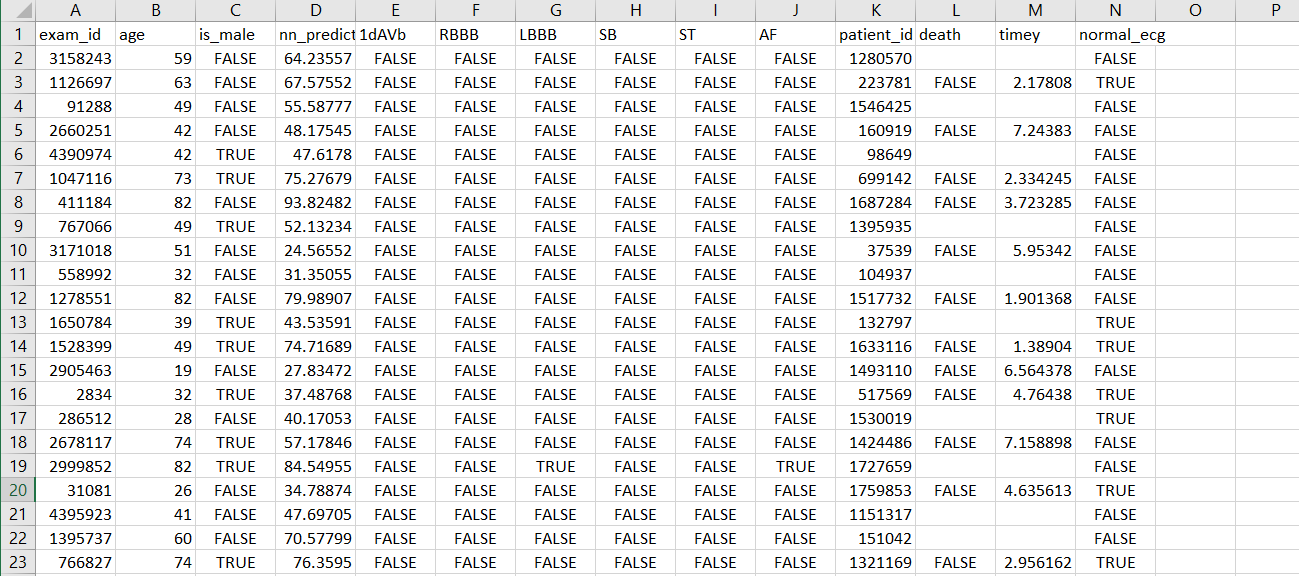

In [4]:
!pip install torch_geometric

In [1]:
import torch
from torch_geometric.data import Data, Dataset
import h5py
import pandas as pd
import numpy as np

class ECGGraphDataset(Dataset):
    def __init__(self, hdf5_paths, hdf5_dset, path_to_csv=None, transform=None):
        """
        Initialization of the ECGGraphDataset class.

        Args:
            hdf5_paths (list of str): List of paths to the HDF5 files containing ECG tracings.
            hdf5_dset (str): Dataset name within each HDF5 file.
            path_to_csv (str, optional): Path to the CSV file containing labels and metadata. Defaults to None.
            transform (callable, optional): Optional transform to be applied on a sample. Defaults to None.
        """
        self.transform = transform
        self.hdf5_paths = hdf5_paths
        self.hdf5_dset = hdf5_dset

        # Initialize empty lists for data accumulation
        self.tracing_ids = []
        self.x_list = []
        self.labels_df = None
        # Process each HDF5 file
        for path in self.hdf5_paths:
            print(path)
            with h5py.File(path, "r") as f:
                # Load ECG data
                x_reduced = f[self.hdf5_dset][:-1]
                # x_reduced = x[:, ::2, :]
                if x_reduced.ndim == 3:
                    x_reduced = x_reduced.transpose(0, 2, 1)
                self.x_list.append(x_reduced)

                # Load exam IDs
                tracing_ids = f['exam_id'][:]
                self.tracing_ids.extend(tracing_ids)

        # Concatenate all ECG data and IDs
        self.x = np.concatenate(self.x_list, axis=0)
        self.n_samples, self.n_leads, self.n_timesteps = self.x.shape

        # Load labels and metadata from the CSV file if provided
        if path_to_csv:
            self.labels_df = pd.read_csv(path_to_csv, index_col="exam_id")
            self.labels_df = self.labels_df.reindex(self.tracing_ids, fill_value=False)
            self.y = self.labels_df[['1dAVb', 'RBBB', 'LBBB', 'SB', 'ST', 'AF']].values.astype(np.float32)
            self.metadata = self.labels_df[['age', 'is_male']].values.astype(np.float32)
        else:
            self.y = None
            self.metadata = None

        # Define the edges for a fully connected graph
        self.edge_index = self._create_fully_connected_graph(self.n_leads)

    def _create_fully_connected_graph(self, num_nodes):
        """
        Create a fully connected graph where each node (lead) is connected to every other node.

        Args:
            num_nodes (int): The number of nodes in the graph (in this case, the number of leads).

        Returns:
            edge_index (torch.Tensor): A 2D tensor representing the edges between the nodes.
        """
        row = np.repeat(np.arange(num_nodes), num_nodes)
        col = np.tile(np.arange(num_nodes), num_nodes)
        edge_index = np.stack([row, col], axis=0)
        return torch.tensor(edge_index, dtype=torch.long)

    def __len__(self):
        """
        Returns the number of samples in the dataset.
        """
        return self.n_samples

    def __getitem__(self, idx):
        node_features = torch.tensor(self.x[idx], dtype=torch.float)

        if self.y is not None:
            label = torch.tensor(self.y[idx], dtype=torch.float)
            if len(label.shape) == 1:
                label = label.unsqueeze(0)
        else:
            label = None

        metadata = torch.tensor(self.metadata[idx], dtype=torch.float) if self.metadata is not None else None
        graph_id = self.tracing_ids[idx] if self.tracing_ids is not None else None

        graph_data = Data(x=node_features, edge_index=self.edge_index)

        if label is not None:
            graph_data.y = label
        if metadata is not None:
            graph_data.metadata = metadata
        if graph_id is not None:
            graph_data.id = graph_id

        if self.transform:
            graph_data = self.transform(graph_data)

        return graph_data



In [5]:
!ls

dataset  parts	sample_data


In [2]:
# hdf5_files = ["dataset/exams_part0.hdf5", "dataset/exams_part1.hdf5"]
hdf5_files = ["dataset/exams_part0.hdf5"]

# Load the dataset by concatenating the HDF5 files
dataset = ECGGraphDataset(hdf5_paths=hdf5_files, hdf5_dset="tracings", path_to_csv="dataset/part0.csv")


dataset/exams_part0.hdf5


In [3]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
# print(f'Number of classes: {dataset.num_classes}')
data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: ECGGraphDataset(20000):
Number of graphs: 20000
Number of features: 4096

Data(x=[12, 4096], edge_index=[2, 144], y=[1, 6], metadata=[2], id=590673)
Number of nodes: 12
Number of edges: 144
Average node degree: 12.00
Has isolated nodes: False
Has self-loops: True
Is undirected: True


In [4]:
from torch_geometric.data import DataLoader
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [5]:
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 32
DataBatch(x=[384, 4096], edge_index=[2, 4608], y=[32, 6], metadata=[64], id=[32], batch=[384], ptr=[33])

Step 2:
Number of graphs in the current batch: 32
DataBatch(x=[384, 4096], edge_index=[2, 4608], y=[32, 6], metadata=[64], id=[32], batch=[384], ptr=[33])

Step 3:
Number of graphs in the current batch: 32
DataBatch(x=[384, 4096], edge_index=[2, 4608], y=[32, 6], metadata=[64], id=[32], batch=[384], ptr=[33])

Step 4:
Number of graphs in the current batch: 32
DataBatch(x=[384, 4096], edge_index=[2, 4608], y=[32, 6], metadata=[64], id=[32], batch=[384], ptr=[33])

Step 5:
Number of graphs in the current batch: 32
DataBatch(x=[384, 4096], edge_index=[2, 4608], y=[32, 6], metadata=[64], id=[32], batch=[384], ptr=[33])

Step 6:
Number of graphs in the current batch: 32
DataBatch(x=[384, 4096], edge_index=[2, 4608], y=[32, 6], metadata=[64], id=[32], batch=[384], ptr=[33])

Step 7:
Number of graphs in the current batch: 32
DataBatch(x=[3

In [6]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_classes):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)

        return x



In [7]:
model = GCN(hidden_channels=64, num_classes=6)
print(model)

GCN(
  (conv1): GCNConv(4096, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=6, bias=True)
)


In [10]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        #  print(f"Shape of out: {out.shape}")
        #  print(f"Shape of data.y: {data.y.shape}")
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()

    correct = 0
    total_samples = 0
    total_labels = 0

    with torch.no_grad():
        for data in loader:  # Iterate in batches over the test dataset.
            # Perform a forward pass
            out = model(data.x, data.edge_index, data.batch)

            # Apply a threshold to obtain binary predictions for multilabel classification
            # For example, you might use a threshold of 0.5
            threshold = 0.5
            pred = (out > threshold).float()  # Apply threshold to get binary predictions

            # Compare predictions to ground-truth labels
            correct += (pred == data.y).float().sum().item()  # Count correct predictions
            total_samples += data.y.size(0)  # Number of samples in the batch
            total_labels += data.y.numel()  # Total number of labels across all samples

    # Compute accuracy as the ratio of correct predictions to total labels
    accuracy = correct / total_labels
    return accuracy

for epoch in range(1, 171):
    train()
    train_acc = test(train_loader)
    # test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}')
    # print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Train Acc: 0.9691
Epoch: 002, Train Acc: 0.9798
Epoch: 003, Train Acc: 0.9799
Epoch: 004, Train Acc: 0.9799
Epoch: 005, Train Acc: 0.9797
Epoch: 006, Train Acc: 0.9799


KeyboardInterrupt: 

In [6]:
# Get a sample from the dataset (e.g., first sample)
sample = dataset[25]  # Change index for a different sample

# Print node features (ECG signals for each lead)
print("Node features (ECG signal for each lead):")
print(sample.x)  # Node features

# Print the label (diagnostic labels) if available
if sample.y is not None:
    print("\nLabel (diagnostic information):")
    print(sample.y)

Node features (ECG signal for each lead):
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

Label (diagnostic information):
tensor([0., 0., 0., 0., 0., 0.])


In [7]:
# Function to find a sample with at least one label equal to 1
def find_sample_with_label_one(dataset):
    for i in range(len(dataset)):
        sample = dataset[i]
        if sample.y is not None and torch.any(sample.y == 1):
            return sample, i
    return None, -1

# Get a sample whose label contains at least one `1`
sample, idx = find_sample_with_label_one(dataset)

if sample is not None:
    print(f"Sample with label containing at least one '1' found at index {idx}:")

    # Print node features (ECG signals for each lead)
    print("\nNode features (ECG signal for each lead):")
    print(sample.x.shape[1])

    # Print the label (diagnostic labels)
    print("\nLabel (diagnostic information):")
    print(sample.y)

    # Now let's use the edge_index from the dataset to print the actual adjacency matrix
    num_nodes = sample.x.size(0)  # Number of nodes (leads)
    print(num_nodes, sample.metadata, sample.id)
    print(sample.edge_index)



Sample with label containing at least one '1' found at index 5:

Node features (ECG signal for each lead):
2048

Label (diagnostic information):
tensor([0., 1., 0., 0., 0., 0.])
12 tensor([78.,  0.]) 223229
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,
          4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
          6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,
          7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
          9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0,  1,  2,  3,  4,  5,
          6,  7,  8,  9, 10, 11,  0,  1,  2,  3,  4,  5,  6,  7